# CS7643: GPT2 From Scratch & Fine Tuning

# 0. Setup

### [Optional] Set up Google Drive Connection

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded assignment1
# Example: If you create a Fall2023 folder and put all the files under A1 folder, then 'Fall2023/A1'
GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'cs7643/project'
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['model', 'natural_langauge_entailment', 'nle']


In [ ]:
import sys
import numpy as np
import math
sys.path.append(GOOGLE_DRIVE_PATH)

In [ ]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python311.zip',
 '/usr/lib/python3.11',
 '/usr/lib/python3.11/lib-dynload',
 '',
 '/usr/local/lib/python3.11/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.11/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/cs7643/project']

In [ ]:
# if running locally set GOOGLE PATH
import sys
if 'google.colab' in sys.modules:
  print(f'Running in google colab. Our path is `{GOOGLE_DRIVE_PATH}`')
else:
  GOOGLE_DRIVE_PATH = '.'
  print('Running locally.')

Running in google colab. Our path is `/content/drive/MyDrive/cs7643/project`


### Import Modules

In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.4 MB/s eta 0:00:00


In [ ]:
from importlib.metadata import version
import tiktoken
print("tiktoken version:", version("tiktoken"))

tiktoken version: 0.9.0


In [ ]:
import torch
import gc
print("torch version:", version("torch"))

device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device = " + device)
if device == 'cpu':
    print("WARNING: Using CPU will cause slower train times")
torch.cuda.empty_cache()
gc.collect()

torch version: 2.6.0+cu124
Using device = cuda


60

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:

from torch import nn

In [ ]:
import pandas as pd

In [ ]:
import urllib
from pathlib import Path
import time
from tqdm import tqdm

# 1. Implement a GPT-2 Model

In [ ]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(".."))

from model.gpt import GPTModel, text_to_token_ids, token_ids_to_text, generate, print_model_stats, TransformerBlock, classify_text_simple
from model.load_model import load_weights
from model.lora_gpt import LoRALayer, LinearWithLoRA, replace_linear_with_lora, replace_linear_with_lora_last_n

## 1.0 Utils

In [ ]:
# !pip install transformers
from transformers import GPT2Model

# Available Models Names
model_names = {
    "gpt2-small (124M)": "openai-community/gpt2",
    "gpt2-medium (355M)": "openai-community/gpt2-medium",
    "gpt2-large (774M)": "openai-community/gpt2-large",
    "gpt2-xl (1558M)": "openai-community/gpt2-xl"
}

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

def get_raw_gpt(model_name):
    if model_name not in model_configs:
        raise ValueError(f"Unknown model name: {model_name}")

    base_config_copy = BASE_CONFIG.copy()
    base_config_copy.update(model_configs[model_name])
    return GPTModel(base_config_copy)

def get_pretrained_gpt_model(model_name, verbose=True):
    if model_name not in model_configs:
        raise ValueError(f"Unknown model name: {model_name}")

    base_config_copy = BASE_CONFIG.copy()
    base_config_copy.update(model_configs[model_name])
    gpt_model = GPTModel(base_config_copy)

    hf_pretrained_gpt = GPT2Model.from_pretrained(model_names[model_name], cache_dir="checkpoints")
    load_weights(gpt_model, hf_pretrained_gpt, base_config_copy)

    if verbose:
        print_model_stats(gpt_model, model_name)

    return gpt_model

In [ ]:
def convert_to_lora_model(model: GPTModel, rank: int, alpha: int, last_n_trf_blocks=None) -> GPTModel:
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters before: {total_params:,}")

    for param in model.parameters():
        param.requires_grad = False

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters after: {total_params:,}")

    if last_n_trf_blocks is not None:
        replace_linear_with_lora_last_n(model, n=last_n_trf_blocks, rank=rank, alpha=alpha)
    else:
        replace_linear_with_lora(model, rank=rank, alpha=alpha)

    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable LoRA parameters: {total_params:,}")
    model.to(device)
    return model

In [ ]:
from nle.train import calc_batch_loss, calc_loader_loss, evaluate_model, generate_and_print_sample, TrainingConfig, TrainingResults, train_model_simple, train_model,calc_loader_accuracy
from nle.train_plots import plot_losses, plot_perplexity, plot_and_save_learning_rate
from nle.ClassificationDataset import ClassificationDataset, classification_collate_fn
from nle.NLEWithGPT import NLEWithGPT

In [ ]:
def print_model_losses(model, train_loader, val_loader, device):
    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, model, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, model, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)
    print("Training perplexity:", torch.exp(torch.tensor(train_loss)).item())
    print("Validation perplexity:", torch.exp(torch.tensor(val_loss)).item())

In [ ]:
import json

def download_and_load_json_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data

In [ ]:
def format_input(entry):
    instruction_text = (
        f"Below is a natural language entailment data classification. "
        f"Write a response that appropriately determines the medical relationship between a premise (sentence 1) and a hypothesis (sentence 2)"
        f"\n\n### Premise:\n{entry['sentence1']}"
        f"\n\n### hypothesis:\n{entry['sentence2']}"
    )

    return instruction_text

def format_response(entry):
    return entry['gold_label']

In [ ]:
def load_json_data(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    return data

In [ ]:
def generate_model_response(model, test_data, file_path=None):
    model.eval()
    with torch.no_grad():
        for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
            instruction_text = format_input(entry)
            token_ids = generate(
                model=model.to(device),
                token_ids=text_to_token_ids(instruction_text, tokenizer).to(device),
                max_new_tokens=512,
                context_size=BASE_CONFIG["context_length"],
                eos_id=50256,
            )
            generated_text = token_ids_to_text(token_ids, tokenizer)

            response_text = generated_text[len(instruction_text):].replace("### Response:", "").strip()
            entry["generated_text"] = response_text

    # Save the data
    if file_path:
        with open(file_path, 'w') as f:
            json.dump(test_data, f, indent=4)

    return test_data

In [ ]:
def print_model_losses(model, train_loader, val_loader, device):
    with torch.no_grad():
        train_loss = calc_loader_loss(train_loader, model, device, num_batches=5)
        val_loss = calc_loader_loss(val_loader, model, device, num_batches=5)

    print("Training loss:", train_loss)
    print("Validation loss:", val_loss)
    print("Training perplexity:", torch.exp(torch.tensor(train_loss)).item())
    print("Validation perplexity:", torch.exp(torch.tensor(val_loss)).item())
    print()

In [ ]:
def filter_data_by_len(data_type="train", target_size=12000, filepath=None):
    splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
    path = "hf://datasets/presencesw/all_nli_med_v1/" + splits[data_type]
    data = pd.read_parquet("hf://datasets/presencesw/all_nli_med_v1/" + splits[data_type])

    entailment_subset = data[data["gold_label"] == "entailment"].sample(int(target_size/3), random_state=123)
    contradict_subset = data[data["gold_label"] == "contradiction"].sample(int(target_size/3), random_state=123)
    neutral_subset = data[data["gold_label"] == "neutral"].sample(int(target_size/3), random_state=123)


    # Combine both subsets
    sample_df = pd.concat([entailment_subset, contradict_subset,neutral_subset])

    # Shuffle the dataset
    sample_df = sample_df.sample(frac=1, random_state=123).reset_index(drop=True)


    if filepath:
        sample_df.to_json(filepath, orient='records', indent=4)  # Save as JSON

    return sample_df

## 5.2 Organizing data into training batches

## 5.1 Prepare Dataset

In [ ]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
train_data = filter_data_by_len(data_type="train", target_size=12000)
val_data = filter_data_by_len(data_type="validation", target_size=2000)
test_data = filter_data_by_len(data_type="test", target_size=2000)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print("Example entry:\n", train_data.iloc[50])
print(type(train_data))

Example entry:
 gold_label                                           entailment
sentence1     Cardio-ankle vascular index (CAVI) has been es...
sentence2     In conclusion, the increase in the CAVI preced...
Name: 50, dtype: object
<class 'pandas.core.frame.DataFrame'>


In [ ]:
def save_first_n_entries(data, n, filename):
    """Saves the first n entries of the data to a JSON file."""
    try:
        with open(filename, 'w') as f:
            json.dump(data.head(n).to_dict(orient='records'), f, indent=4) # Use indent for pretty printing
        print(f"Successfully saved the first {n} entries to {filename}")
    except Exception as e:
        print(f"An error occurred: {e}")

save_first_n_entries(
    train_data, 30,
    "nle_sample_generation_data_30.json")

Successfully saved the first 30 entries to nle_sample_generation_data_30.json


In [ ]:
print(format_input(train_data.iloc[50]))
print("label: " + format_response(train_data.iloc[50]))

Below is a natural language entailment data classification. Write a response that appropriately determines the medical relationship between a premise (sentence 1) and a hypothesis (sentence 2)

### Premise:
Cardio-ankle vascular index (CAVI) has been established as a marker of arterial stiffness, which is increased in hypertensive patients. CAVI reflects the stiffness of the aorta, femoral artery, and tibial artery. Sunitinib, multi-targeted tyrosine kinase inhibitor with both anti-angiogenic and anti-tumor activities, has been proved effective in patients with gastrointestinal stromal tumors. However, the treatment with sunitinib is often complicated by side effects such as hypertension. We describe an 84-year-old woman with gastrointestinal stromal tumor, who showed changes in arterial stiffness preceding the appearance of hypertension in the early phase after sunitinib initiation. The patient received sunitinib (50 mg given daily) for gastrointestinal stromal tumor. We assessed the 

In [ ]:
# train_portion = int(len(data) * 0.85)  # 85% for training
# test_portion = int(len(data) * 0.1)    # 10% for testing
# val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

# train_data = data[:train_portion]
# test_data = data[train_portion:train_portion + test_portion]
# val_data = data[train_portion + test_portion:]

In [ ]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 12000
Validation set length: 1998
Test set length: 1998


## 5.3 Creating data loaders for classification datasets

In [ ]:
from functools import partial
tokenizer = tiktoken.get_encoding("gpt2")
customized_collate_fn = partial(
    classification_collate_fn,
    tokenizer=tokenizer,
    allowed_max_length=1024,
    pad_token_id=50256,
    device=device
    # device="cpu"
)

num_workers = 0
batch_size = 4

torch.manual_seed(123)

train_dataset = ClassificationDataset(train_data, tokenizer,max_length=1024)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    # collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = ClassificationDataset(val_data, tokenizer,max_length=1024)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    # collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = ClassificationDataset(test_data, tokenizer,max_length=1024)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    # collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

print(len(train_loader))

3000


In [ ]:
print("Train loader:")
i = 0
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)
    if i == 3: break
    i += 1

Train loader:
torch.Size([4, 1024]) torch.Size([4])
torch.Size([4, 1024]) torch.Size([4])
torch.Size([4, 1024]) torch.Size([4])
torch.Size([4, 1024]) torch.Size([4])


## 5.4 Loading a pretrained LLM

In [ ]:
# CHOOSE_MODEL = "gpt2-large (774M)"
CHOOSE_MODEL = "gpt2-medium (355M)"
gpt_m = get_pretrained_gpt_model(CHOOSE_MODEL)
# nleModel = NLEWithGPT(gpt_m)
nleModel = NLEWithGPT(gpt_m).to(device)

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB


In [ ]:
input_text = format_input(val_data.iloc[0])
print(input_text)

Below is a natural language entailment data classification. Write a response that appropriately determines the medical relationship between a premise (sentence 1) and a hypothesis (sentence 2)

### Premise:
HISTORY OF PRESENT ILLNESS:  Baby Girl [**Known patient lastname **] #2 is the 1755 gram product of a 33 and [**1-2**] week triplet gestation by IVF conception, born to a 35 year-old, Gravida 0, now 3 mom.

### hypothesis:
 the patient is breathing normally


In [ ]:
torch.manual_seed(123)

tokenizer = tiktoken.get_encoding("gpt2")
# token_ids = text_to_token_ids(input_text, tokenizer)
token_ids = text_to_token_ids(input_text, tokenizer).to(device)
classified_label = classify_text_simple(nleModel, token_ids)
print("Output label: ", classified_label)


Output label:  entailment


In [ ]:
def save_training_results(results: TrainingResults, filename: str):
    results_dict = {
        "train_losses": results.train_losses,
        "val_losses": results.val_losses,
        "track_tokens_seen": results.track_tokens_seen,
    }
    if results.track_lrs is not None:
        results_dict["track_lrs"] = results.track_lrs

    with open(filename, "w") as f:
        json.dump(results_dict, f)
        print(f"Training results saved to {filename}")

## 5.5 Finetuning the LLM on NLE data

Initial Loss

In [ ]:
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loader_loss(train_loader, nleModel, device, num_batches=5)
    val_loss = calc_loader_loss(val_loader, nleModel, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 1.7346501708030702
Validation loss: 1.0853593587875365


In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(nleModel.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs = 2

training_config = TrainingConfig(
    model=nleModel,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    tokenizer=tokenizer,
)

training_results = train_model_simple(training_config)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 4.320, Val loss 5.173
Ep 1 (Step 000005): Train loss 1.356, Val loss 1.471
Ep 1 (Step 000010): Train loss 1.687, Val loss 1.501
Ep 1 (Step 000015): Train loss 2.177, Val loss 2.210
Ep 1 (Step 000020): Train loss 1.088, Val loss 1.102
Ep 1 (Step 000025): Train loss 1.917, Val loss 0.954
Ep 1 (Step 000030): Train loss 1.396, Val loss 0.913
Ep 1 (Step 000035): Train loss 0.924, Val loss 0.985
Ep 1 (Step 000040): Train loss 1.163, Val loss 1.354
Ep 1 (Step 000045): Train loss 1.119, Val loss 1.151
Ep 1 (Step 000050): Train loss 1.054, Val loss 0.967
Ep 1 (Step 000055): Train loss 0.998, Val loss 1.024
Ep 1 (Step 000060): Train loss 1.165, Val loss 1.295
Ep 1 (Step 000065): Train loss 1.083, Val loss 1.456
Ep 1 (Step 000070): Train loss 1.243, Val loss 1.293
Ep 1 (Step 000075): Train loss 1.085, Val loss 1.131
Ep 1 (Step 000080): Train loss 1.104, Val loss 1.019
Ep 1 (Step 000085): Train loss 1.000, Val loss 0.946
Ep 1 (Step 000090): Train loss 1.038, Val loss

Plotting losses...


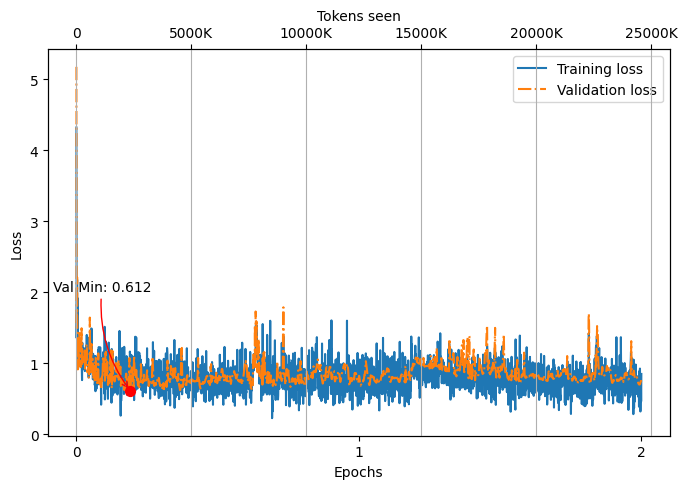

In [ ]:
epochs_tensor = torch.linspace(
    0, num_epochs, len(training_results.train_losses))

plot_losses(training_config,training_results)
            # ift_mini_alpaca_training_results.track_tokens_seen,
            # ift_mini_alpaca_training_results.train_losses,
            # ift_mini_alpaca_training_results.val_losses)

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 406,286,336
Total trainable parameters after: 0
Total trainable LoRA parameters: 3,949,192
Training loss: 7.880757904052734
Validation loss: 7.791268539428711
Training perplexity: 2645.876953125
Validation perplexity: 2419.38427734375

Ep 1 (Iter 000000): Train loss 5.268, Val loss 5.671
Ep 1 (Iter 000025): Train loss 1.144, Val loss 1.406
Ep 1 (Iter 000050): Train loss 1.465, Val loss 1.179
Ep 1 (Iter 000075): Train loss 1.345, Val loss 1.260
Ep 1 (Iter 000100): Train loss 1.061, Val loss 1.078
Ep 1 (Iter 000125): Train loss 1.317, Val loss 0.967
Ep 1 (Iter 000150): Train loss 0.998, Val loss 1.014
Ep 1 (Iter 000175): Train loss 1.152, Val loss 1.080
Ep 1 (Iter 000200): Train loss 1.111, Val loss 1.174
Ep 1 (Iter 000225): Train loss 1.404, Val loss 1.810
Ep 1 (Iter 000250): Train loss 1.123, Val loss 1.089
Ep 1 (Iter 000275): Train loss 1.062, Val loss

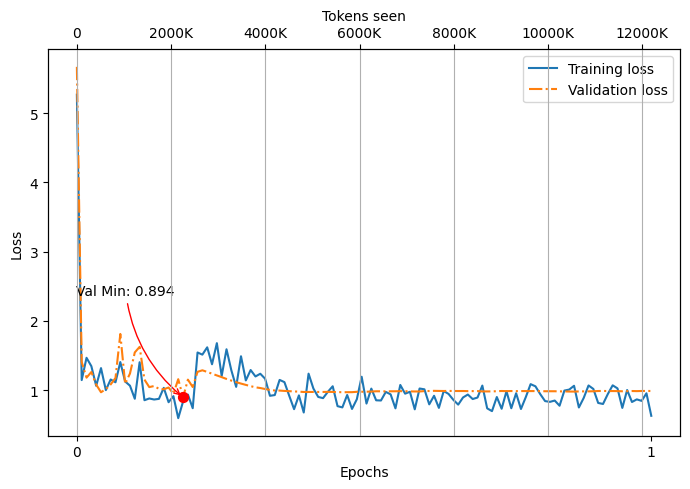

In [ ]:
run_name = "medium_lora_r8_a8"
# 1) Initialize a Pre-trained GPT model
CHOOSE_MODEL = "gpt2-medium (355M)"
# CHOOSE_MODEL = "gpt2-large (774M)"
pretrained_gpt_m = get_pretrained_gpt_model(CHOOSE_MODEL)
pretrained_gpt_m.to(device)

pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=8, alpha=8, last_n_trf_blocks=None)
print_model_losses(pretrained_gpt_m, train_loader, val_loader, device)

# 2) Finetune the model
start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 1
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup

training_config = TrainingConfig(
    model=pretrained_gpt_m,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=25,
    eval_iter=5,
    tokenizer=tokenizer,
    warmup_steps=warmup_steps,
    initial_lr=1e-5,
    min_lr=1e-5,
    run_name=run_name,
)
# ift_alpaca_training_results = train_model_simple(ift_alpaca_training_config)
training_results = train_model(training_config)

train_accuracy = calc_loader_accuracy(train_loader, pretrained_gpt_m, device)
val_accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device)
test_accuracy = calc_loader_accuracy(test_loader, pretrained_gpt_m, device)
print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

# 3) Saving and logging
directory_path = f"{GOOGLE_DRIVE_PATH}/nle/data/runs/{run_name}/"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# 3a) Save GPT model
# model_file_path = directory_path + "pretrained_gpt_m.pth"
# torch.save(pretrained_gpt_m.state_dict(), model_file_path)

# 3b) Save training results
training_results_file_path = directory_path + "training_results.json"
save_training_results(training_results, training_results_file_path)

# 3c) Plot learning curves
plot_losses(training_config, training_results, directory_path + "loss_curves.png")


In [ ]:
medium_lora_r2_a2 = lora_finetune_model("medium_lora_r2_a2")

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 406,286,336
Total trainable parameters after: 0
Total trainable LoRA parameters: 987,298
Training loss: 7.993992519378662
Validation loss: 7.791268539428711
Training perplexity: 2963.10302734375
Validation perplexity: 2419.38427734375

Ep 1 (Iter 000000): Train loss 6.985, Val loss 7.508
Ep 1 (Iter 000025): Train loss 3.354, Val loss 3.621
Ep 1 (Iter 000050): Train loss 1.965, Val loss 2.011
Ep 1 (Iter 000075): Train loss 1.320, Val loss 1.460
Ep 1 (Iter 000100): Train loss 1.256, Val loss 1.167
Ep 1 (Iter 000125): Train loss 1.282, Val loss 1.170
Ep 1 (Iter 000150): Train loss 0.956, Val loss 1.289
Ep 1 (Iter 000175): Train loss 1.384, Val loss 1.292
Ep 1 (Iter 000200): Train loss 1.157, Val loss 1.174
Ep 1 (Iter 000225): Train loss 1.128, Val loss 1.166
Ep 1 (Iter 000250): Train loss 1.197, Val loss 1.131
Ep 1 (Iter 000275): Train loss 1.185, Val loss

AttributeError: 'TrainingConfig' object has no attribute 'track_tokens_seen'

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 406,286,336
Total trainable parameters after: 0
Total trainable LoRA parameters: 7,898,384
Training loss: 8.238009166717529
Validation loss: 7.791268539428711
Training perplexity: 3782.004638671875
Validation perplexity: 2419.38427734375

Ep 1 (Iter 000000): Train loss 3.481, Val loss 3.899
Ep 1 (Iter 000025): Train loss 1.048, Val loss 1.123
Ep 1 (Iter 000050): Train loss 1.239, Val loss 1.064
Ep 1 (Iter 000075): Train loss 1.262, Val loss 1.223
Ep 1 (Iter 000100): Train loss 1.025, Val loss 1.016
Ep 1 (Iter 000125): Train loss 1.366, Val loss 0.942
Ep 1 (Iter 000150): Train loss 0.896, Val loss 0.988
Ep 1 (Iter 000175): Train loss 1.031, Val loss 1.035
Ep 1 (Iter 000200): Train loss 1.071, Val loss 1.197
Ep 1 (Iter 000225): Train loss 1.417, Val loss 1.920
Ep 1 (Iter 000250): Train loss 1.098, Val loss 1.181
Ep 1 (Iter 000275): Train loss 1.021, Val l

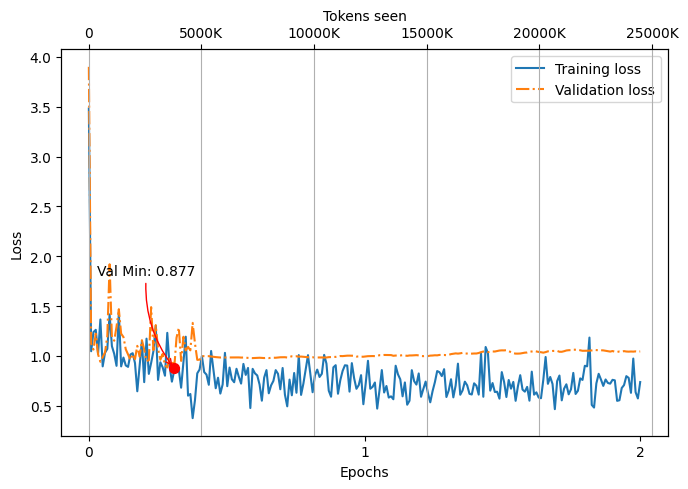

In [ ]:
run_name = "medium_lora_r16_a16"
# 1) Initialize a Pre-trained GPT model
CHOOSE_MODEL = "gpt2-medium (355M)"
# CHOOSE_MODEL = "gpt2-large (774M)"
pretrained_gpt_m = get_pretrained_gpt_model(CHOOSE_MODEL)
pretrained_gpt_m.to(device)

pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=16, alpha=16, last_n_trf_blocks=None)
print_model_losses(pretrained_gpt_m, train_loader, val_loader, device)

# 2) Finetune the model
start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 2
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup

training_config = TrainingConfig(
    model=pretrained_gpt_m,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=25,
    eval_iter=5,
    tokenizer=tokenizer,
    warmup_steps=warmup_steps,
    initial_lr=1e-5,
    min_lr=1e-5,
    run_name=run_name,
)
# ift_alpaca_training_results = train_model_simple(ift_alpaca_training_config)
training_results = train_model(training_config)

train_accuracy = calc_loader_accuracy(train_loader, pretrained_gpt_m, device)
val_accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device)
test_accuracy = calc_loader_accuracy(test_loader, pretrained_gpt_m, device)
print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

# 3) Saving and logging
directory_path = f"{GOOGLE_DRIVE_PATH}/nle/data/runs/{run_name}/"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# 3a) Save GPT model
# model_file_path = directory_path + "pretrained_gpt_m.pth"
# torch.save(pretrained_gpt_m.state_dict(), model_file_path)

# 3b) Save training results
training_results_file_path = directory_path + "training_results.json"
save_training_results(training_results, training_results_file_path)

# 3c) Plot learning curves
plot_losses(training_config, training_results, directory_path + "loss_curves.png")


In [ ]:
run_name = "large_lora_r8_a8"
# 1) Initialize a Pre-trained GPT model
# CHOOSE_MODEL = "gpt2-medium (355M)"
CHOOSE_MODEL = "gpt2-large (774M)"
pretrained_gpt_m = get_pretrained_gpt_model(CHOOSE_MODEL)
pretrained_gpt_m.to(device)

pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=8, alpha=8, last_n_trf_blocks=None)
print_model_losses(pretrained_gpt_m, train_loader, val_loader, device)

# 2) Finetune the model
start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 1
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup

training_config = TrainingConfig(
    model=pretrained_gpt_m,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=25,
    eval_iter=5,
    tokenizer=tokenizer,
    warmup_steps=warmup_steps,
    initial_lr=1e-5,
    min_lr=1e-5,
    run_name=run_name,
)
# ift_alpaca_training_results = train_model_simple(ift_alpaca_training_config)
training_results = train_model(training_config)

train_accuracy = calc_loader_accuracy(train_loader, pretrained_gpt_m, device)
val_accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device)
test_accuracy = calc_loader_accuracy(test_loader, pretrained_gpt_m, device)
print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

# 3) Saving and logging
directory_path = f"{GOOGLE_DRIVE_PATH}/nle/data/runs/{run_name}/"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# 3a) Save GPT model
# model_file_path = directory_path + "pretrained_gpt_m.pth"
# torch.save(pretrained_gpt_m.state_dict(), model_file_path)

# 3b) Save training results
training_results_file_path = directory_path + "training_results.json"
save_training_results(training_results, training_results_file_path)

# 3c) Plot learning curves
plot_losses(training_config, training_results, directory_path + "loss_curves.png")


Model Name: gpt2-large (774M)
	Total Parameters: 838,359,040
	Total Memory Requirement: 3198.09 MB
Total trainable parameters before: 838,359,040
Total trainable parameters after: 0
Total trainable LoRA parameters: 7,047,816
Training loss: 6.641598320007324
Validation loss: 9.436892890930176
Training perplexity: 766.3187866210938
Validation perplexity: 12542.6796875

Ep 1 (Iter 000000): Train loss 6.882, Val loss 6.792
Ep 1 (Iter 000025): Train loss 1.463, Val loss 1.256
Ep 1 (Iter 000050): Train loss 0.905, Val loss 1.513
Ep 1 (Iter 000075): Train loss 1.044, Val loss 1.074
Ep 1 (Iter 000100): Train loss 1.112, Val loss 1.272
Ep 1 (Iter 000125): Train loss 1.179, Val loss 1.037
Ep 1 (Iter 000150): Train loss 1.030, Val loss 1.007
Ep 1 (Iter 000175): Train loss 1.195, Val loss 1.319
Ep 1 (Iter 000200): Train loss 1.005, Val loss 1.129
Ep 1 (Iter 000225): Train loss 1.054, Val loss 1.168
Ep 1 (Iter 000250): Train loss 1.100, Val loss 0.963
Ep 1 (Iter 000275): Train loss 1.322, Val loss 

In [ ]:
run_name = "large_lora_r32_a32"
# 1) Initialize a Pre-trained GPT model
# CHOOSE_MODEL = "gpt2-medium (355M)"
CHOOSE_MODEL = "gpt2-large (774M)"
pretrained_gpt_m = get_pretrained_gpt_model(CHOOSE_MODEL)
pretrained_gpt_m.to(device)

pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=32, alpha=32, last_n_trf_blocks=None)
print_model_losses(pretrained_gpt_m, train_loader, val_loader, device)

# 2) Finetune the model
start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 1
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup

training_config = TrainingConfig(
    model=pretrained_gpt_m,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=25,
    eval_iter=5,
    tokenizer=tokenizer,
    warmup_steps=warmup_steps,
    initial_lr=1e-5,
    min_lr=1e-5,
    run_name=run_name,
)
# ift_alpaca_training_results = train_model_simple(ift_alpaca_training_config)
training_results = train_model(training_config)

train_accuracy = calc_loader_accuracy(train_loader, pretrained_gpt_m, device)
val_accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device)
test_accuracy = calc_loader_accuracy(test_loader, pretrained_gpt_m, device)
print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

# 3) Saving and logging
directory_path = f"{GOOGLE_DRIVE_PATH}/nle/data/runs/{run_name}/"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# 3a) Save GPT model
# model_file_path = directory_path + "pretrained_gpt_m.pth"
# torch.save(pretrained_gpt_m.state_dict(), model_file_path)

# 3b) Save training results
training_results_file_path = directory_path + "training_results.json"
save_training_results(training_results, training_results_file_path)

# 3c) Plot learning curves
plot_losses(training_config, training_results, directory_path + "loss_curves.png")


Model Name: gpt2-large (774M)
	Total Parameters: 838,359,040
	Total Memory Requirement: 3198.09 MB
Total trainable parameters before: 838,359,040
Total trainable parameters after: 0
Total trainable LoRA parameters: 28,191,264
Training loss: 8.718159770965576
Validation loss: 9.436892890930176
Training perplexity: 6112.9189453125
Validation perplexity: 12542.6796875

Ep 1 (Iter 000000): Train loss 4.545, Val loss 3.137
Ep 1 (Iter 000025): Train loss 1.120, Val loss 1.181
Ep 1 (Iter 000050): Train loss 1.151, Val loss 1.310
Ep 1 (Iter 000075): Train loss 1.133, Val loss 1.228
Ep 1 (Iter 000100): Train loss 1.128, Val loss 1.309
Ep 1 (Iter 000125): Train loss 1.074, Val loss 1.185
Ep 1 (Iter 000150): Train loss 1.090, Val loss 1.081
Ep 1 (Iter 000175): Train loss 1.311, Val loss 1.446
Ep 1 (Iter 000200): Train loss 1.040, Val loss 1.079
Ep 1 (Iter 000225): Train loss 1.078, Val loss 1.165
Ep 1 (Iter 000250): Train loss 1.146, Val loss 0.959
Ep 1 (Iter 000275): Train loss 1.059, Val loss 1

In [ ]:
run_name = "medium_lora_r16_a16_b18"
# 1) Initialize a Pre-trained GPT model
CHOOSE_MODEL = "gpt2-medium (355M)"
# CHOOSE_MODEL = "gpt2-large (774M)"
pretrained_gpt_m = get_pretrained_gpt_model(CHOOSE_MODEL)
pretrained_gpt_m.to(device)

pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=16, alpha=16, last_n_trf_blocks=18)
print_model_losses(pretrained_gpt_m, train_loader, val_loader, device)

# 2) Finetune the model
start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 1
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup

training_config = TrainingConfig(
    model=pretrained_gpt_m,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=25,
    eval_iter=5,
    tokenizer=tokenizer,
    warmup_steps=warmup_steps,
    initial_lr=1e-5,
    min_lr=1e-5,
    run_name=run_name,
)
# ift_alpaca_training_results = train_model_simple(ift_alpaca_training_config)
training_results = train_model(training_config)

train_accuracy = calc_loader_accuracy(train_loader, pretrained_gpt_m, device)
val_accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device)
test_accuracy = calc_loader_accuracy(test_loader, pretrained_gpt_m, device)
print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

# 3) Saving and logging
directory_path = f"{GOOGLE_DRIVE_PATH}/nle/data/runs/{run_name}/"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# 3a) Save GPT model
# model_file_path = directory_path + "pretrained_gpt_m.pth"
# torch.save(pretrained_gpt_m.state_dict(), model_file_path)

# 3b) Save training results
training_results_file_path = directory_path + "training_results.json"
save_training_results(training_results, training_results_file_path)

# 3c) Plot learning curves
plot_losses(training_config, training_results, directory_path + "loss_curves.png")


Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 406,286,336
Total trainable parameters after: 0
Applying LoRA with rank=16, alpha=16 to the last 18 transformer blocks (indices 6 to 23).
Total trainable LoRA parameters: 6,128,912
Training loss: 7.50602388381958
Validation loss: 8.126642227172852
Training perplexity: 1818.9666748046875
Validation perplexity: 3383.419677734375

Ep 1 (Iter 000000): Train loss 5.156, Val loss 4.858
Ep 1 (Iter 000025): Train loss 1.580, Val loss 1.466
Ep 1 (Iter 000050): Train loss 0.865, Val loss 1.417
Ep 1 (Iter 000075): Train loss 1.145, Val loss 1.127
Ep 1 (Iter 000100): Train loss 1.126, Val loss 1.420
Ep 1 (Iter 000125): Train loss 1.189, Val loss 1.006
Ep 1 (Iter 000150): Train loss 0.971, Val loss 0.977
Ep 1 (Iter 000175): Train loss 1.200, Val loss 1.379
Ep 1 (Iter 000200): Train loss 0.946, Val loss 1.087
Ep 1 (Iter 000225): Train loss 0.990, Val loss 1.064
Ep 1 

NameError: name 'save_training_results' is not defined

In [ ]:
run_name = "medium_lora_r16_a16_b20"
# 1) Initialize a Pre-trained GPT model
CHOOSE_MODEL = "gpt2-medium (355M)"
# CHOOSE_MODEL = "gpt2-large (774M)"
pretrained_gpt_m = get_pretrained_gpt_model(CHOOSE_MODEL)
pretrained_gpt_m.to(device)

pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=16, alpha=16, last_n_trf_blocks=20)
print_model_losses(pretrained_gpt_m, train_loader, val_loader, device)

# 2) Finetune the model
start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 1
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup

training_config = TrainingConfig(
    model=pretrained_gpt_m,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=25,
    eval_iter=5,
    tokenizer=tokenizer,
    warmup_steps=warmup_steps,
    initial_lr=1e-5,
    min_lr=1e-5,
    run_name=run_name,
)
# ift_alpaca_training_results = train_model_simple(ift_alpaca_training_config)
training_results = train_model(training_config)

train_accuracy = calc_loader_accuracy(train_loader, pretrained_gpt_m, device)
val_accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device)
test_accuracy = calc_loader_accuracy(test_loader, pretrained_gpt_m, device)
print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

# 3) Saving and logging
directory_path = f"{GOOGLE_DRIVE_PATH}/nle/data/runs/{run_name}/"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# 3a) Save GPT model
# model_file_path = directory_path + "pretrained_gpt_m.pth"
# torch.save(pretrained_gpt_m.state_dict(), model_file_path)

# 3b) Save training results
training_results_file_path = directory_path + "training_results.json"
save_training_results(training_results, training_results_file_path)

# 3c) Plot learning curves
plot_losses(training_config, training_results, directory_path + "loss_curves.png")


Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 406,286,336
Total trainable parameters after: 0
Applying LoRA with rank=16, alpha=16 to the last 20 transformer blocks (indices 4 to 23).
Total trainable LoRA parameters: 6,718,736
Training loss: 8.723770713806152
Validation loss: 7.791268539428711
Training perplexity: 6147.3173828125
Validation perplexity: 2419.38427734375

Ep 1 (Iter 000000): Train loss 3.519, Val loss 3.955
Ep 1 (Iter 000025): Train loss 1.033, Val loss 1.128
Ep 1 (Iter 000050): Train loss 1.308, Val loss 1.160
Ep 1 (Iter 000075): Train loss 1.161, Val loss 1.221
Ep 1 (Iter 000100): Train loss 1.048, Val loss 1.026
Ep 1 (Iter 000125): Train loss 1.387, Val loss 0.979
Ep 1 (Iter 000150): Train loss 1.117, Val loss 0.956
Ep 1 (Iter 000175): Train loss 1.156, Val loss 1.067
Ep 1 (Iter 000200): Train loss 1.064, Val loss 1.233
Ep 1 (Iter 000225): Train loss 1.605, Val loss 1.831
Ep 1 (It

NameError: name 'save_training_results' is not defined

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Model Name: gpt2-medium (355M)
	Total Parameters: 406,286,336
	Total Memory Requirement: 1549.86 MB
Total trainable parameters before: 406,286,336
Total trainable parameters after: 0
Applying LoRA with rank=16, alpha=16 to the last 24 transformer blocks (indices 0 to 23).
Total trainable LoRA parameters: 7,898,384
Training loss: 8.440868949890136
Validation loss: 7.791268539428711
Training perplexity: 4632.58056640625
Validation perplexity: 2419.38427734375

Ep 1 (Iter 000000): Train loss 3.581, Val loss 3.996
Ep 1 (Iter 000025): Train loss 1.044, Val loss 1.104
Ep 1 (Iter 000050): Train loss 1.282, Val loss 1.090
Ep 1 (Iter 000075): Train loss 1.241, Val loss 1.216
Ep 1 (Iter 000100): Train loss 1.030, Val loss 1.033
Ep 1 (Iter 000125): Train loss 1.353, Val loss 0.943
Ep 1 (Iter 000150): Train loss 1.016, Val loss 0.974
Ep 1 (Iter 000175): Train loss 1.027, Val loss 1.053
Ep 1 (Iter 000200): Train loss 1.113, Val loss 1.203
Ep 1 (Iter 000225): Train loss 1.394, Val loss 1.631
Ep 1 (I

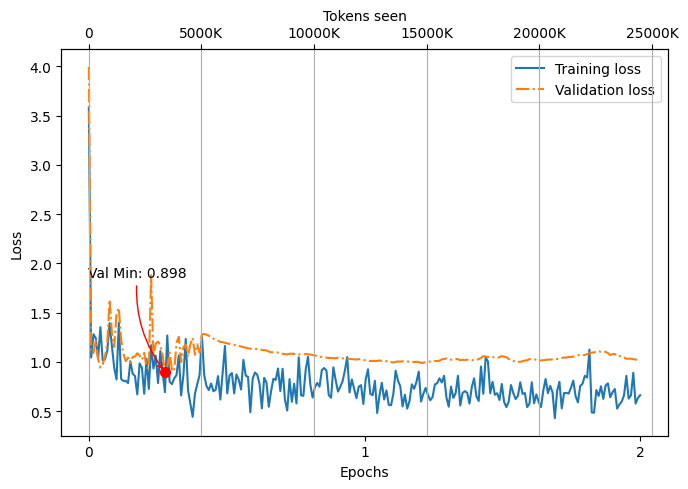

In [ ]:
run_name = "medium_lora_r16_a16_b24"
# 1) Initialize a Pre-trained GPT model
CHOOSE_MODEL = "gpt2-medium (355M)"
# CHOOSE_MODEL = "gpt2-large (774M)"
pretrained_gpt_m = get_pretrained_gpt_model(CHOOSE_MODEL)
pretrained_gpt_m.to(device)

pretrained_gpt_m = convert_to_lora_model(pretrained_gpt_m, rank=16, alpha=16, last_n_trf_blocks=24)
print_model_losses(pretrained_gpt_m, train_loader, val_loader, device)

# 2) Finetune the model
start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(pretrained_gpt_m.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 2
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup

training_config = TrainingConfig(
    model=pretrained_gpt_m,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=25,
    eval_iter=5,
    tokenizer=tokenizer,
    warmup_steps=warmup_steps,
    initial_lr=1e-5,
    min_lr=1e-5,
    run_name=run_name,
)
# ift_alpaca_training_results = train_model_simple(ift_alpaca_training_config)
training_results = train_model(training_config)

train_accuracy = calc_loader_accuracy(train_loader, pretrained_gpt_m, device)
val_accuracy = calc_loader_accuracy(val_loader, pretrained_gpt_m, device)
test_accuracy = calc_loader_accuracy(test_loader, pretrained_gpt_m, device)
print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

# 3) Saving and logging
directory_path = f"{GOOGLE_DRIVE_PATH}/nle/data/runs/{run_name}/"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# 3a) Save GPT model
# model_file_path = directory_path + "pretrained_gpt_m.pth"
# torch.save(pretrained_gpt_m.state_dict(), model_file_path)

# 3b) Save training results
training_results_file_path = directory_path + "training_results.json"
save_training_results(training_results, training_results_file_path)

# 3c) Plot learning curves
plot_losses(training_config, training_results, directory_path + "loss_curves.png")
